<a href="https://colab.research.google.com/github/prog815/abscur/blob/master/%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%B0%D1%8F_%D0%B3%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Простая генетика

**Проект "Абсолютный курс"**

А.В. Енин

г. Оренбург

01.08.2020

Сайт - http://www.abscur.ru

Twitter - https://twitter.com/abscurs

ВКонтакте - https://vk.com/abscur

Одноклассники - https://ok.ru/group/53547043520717

FB - https://www.facebook.com/abscur

Telegram - https://t.me/AbsCur

GitHub - https://github.com/prog815/abscur

WhatsUp - https://chat.whatsapp.com/KrNJXAKizPxDlDSjYfdpQs

Viber - https://invite.viber.com/?g2=AQB63y7Cm%2BNJK0tNZW%2F9kI00M6Wr8HuZ7XeamzN4jZCve8Aq9%2FiD3DY56Eqcf7dc

YouTube - https://www.youtube.com/playlist?list=PLG1V24vhSKo6MamGtgm2oTkDZHeHBHNFW

In [ ]:
! pip install git+https://github.com/prog815/abscur

import abscur

  Cloning https://github.com/prog815/abscur to /tmp/pip-req-build-uf042o04
  Running command git clone -q https://github.com/prog815/abscur /tmp/pip-req-build-uf042o04
  Created wheel for abscur: filename=abscur-0.1.27-cp36-none-any.whl size=10205 sha256=c2e1b2f662346bb609bc31c63837d873f19f3a3f4c6e51bda2594c71d2a6a067
  Stored in directory: /tmp/pip-ephem-wheel-cache-zh9ufnab/wheels/57/99/b6/8f8d84361b37a8789f91280c8e92720b9101beffb944cd32ab
Successfully built abscur


In [ ]:
data = abscur.get_abs_curses()
data

,AUD,CAD,HKD,JPY,SEK,USD,CHF,EUR,CNY,CZK,GBP,ILS,NOK,NZD,RUB,SGD,ZAR,AED,ARS,BRL,CLP,COP,DKK,EGP,HUF,IDR,INR,ISK,KRW,KWD,KZT,MXN,MYR,PEN,PHP,PKR,PLN,QAR,RON,SAR,THB,TRY,TWD,UAH,VND
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-10-03,12.267726,12.222512,2.069556,0.158015,1.871097,16.052485,16.509658,18.023983,2.425955,0.667252,20.753789,4.286751,2.007773,11.661600,0.255285,11.762205,1.168045,4.371473,1.056571,4.924377,0.024429,0.005474,2.421788,1.807061,0.058553,0.001238,0.241222,0.141407,0.014565,53.350012,0.048531,0.831894,3.909519,4.865274,0.332535,0.156686,4.198276,4.407844,4.066700,4.279293,0.464240,5.348030,0.512744,0.630498,0.000730
2016-10-04,12.336633,12.237815,2.069813,0.157633,1.873518,16.053173,16.482127,17.992389,2.406877,0.666122,20.632059,4.278230,2.013136,11.711401,0.257840,11.758835,1.180217,4.371660,1.056895,5.003015,0.024330,0.005578,2.418379,1.811625,0.058550,0.001238,0.241836,0.141102,0.014551,53.341660,0.048240,0.831198,3.871686,4.835147,0.333815,0.155358,4.190258,4.410576,4.047494,4.283588,0.463763,5.316324,0.512684,0.624588,0.000733
2016-10-05,12.258844,12.207638,2.076545,0.156545,1.874351,16.106695,16.460531,18.052503,2.415829,0.668208,20.504357,4.264098,2.011213,11.577777,0.257003,11.745185,1.164986,4.385280,1.062797,4.949054,0.024275,0.005497,2.425959,1.818425,0.058754,0.001236,0.241922,0.141909,0.014441,53.466209,0.048721,0.838506,3.891634,4.875498,0.333824,0.156741,4.194507,4.425281,4.055263,4.298558,0.463235,5.266948,0.511600,0.632007,0.000733
2016-10-06,12.275371,12.221023,2.076021,0.155634,1.875442,16.103412,16.529634,18.046338,2.414708,0.668000,20.537026,4.276515,2.007269,11.551504,0.258449,11.762799,1.173688,4.385341,1.060551,5.003390,0.024285,0.005547,2.425319,1.817377,0.059185,0.001237,0.241927,0.141930,0.014466,53.393276,0.048738,0.837494,3.877537,4.736298,0.334540,0.156026,4.199229,4.424379,4.049441,4.299402,0.462848,5.277004,0.512766,0.628279,0.000731
2016-10-07,12.225387,12.203436,2.079822,0.155470,1.870286,16.132400,16.451010,17.973486,2.418795,0.665308,19.994654,4.267451,2.002549,11.558933,0.259773,11.749199,1.162177,4.393236,1.060714,4.998885,0.024223,0.005671,2.415540,1.817530,0.059222,0.001240,0.241912,0.141376,0.014470,53.533766,0.048680,0.836248,3.887044,4.826592,0.335024,0.155989,4.201901,4.432343,4.020336,4.305992,0.463162,5.302890,0.514000,0.627842,0.000739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-27,12.997253,13.647846,2.362374,0.172753,2.072878,18.310653,19.879515,21.330227,2.610653,0.813332,23.427539,5.374950,1.999535,12.163100,0.255497,13.247933,1.098467,4.986833,0.254827,3.501683,0.023666,0.004963,2.866683,1.146896,0.061694,0.001254,0.244926,0.135334,0.015253,59.846559,0.044498,0.821577,4.298275,5.183483,0.371225,0.109645,4.847551,5.030399,4.413163,4.883492,0.579451,2.676722,0.621733,0.664848,0.000790
2020-07-28,13.044343,13.660207,2.350585,0.173087,2.090314,18.218624,19.813951,21.441514,2.608156,0.820064,23.480490,5.339149,2.008651,12.184348,0.254626,13.220940,1.111232,4.961769,0.253008,3.543500,0.023725,0.004959,2.881144,1.141911,0.061978,0.001247,0.242915,0.135565,0.015234,59.629576,0.044181,0.830532,4.286735,5.183108,0.370674,0.109421,4.883826,5.005804,4.445519,4.863513,0.579473,2.648402,0.624353,0.662951,0.000786
2020-07-29,13.073559,13.651663,2.356585,0.173760,2.082008,18.260667,19.895268,21.401920,2.610547,0.814978,23.599445,5.353929,2.003214,12.161075,0.251935,13.242957,1.107778,4.972678,0.253424,3.544178,0.023845,0.004907,2.875152,1.144016,0.061706,0.001248,0.243184,0.135214,0.015225,59.773051,0.044247,0.832551,4.297639,5.196547,0.371265,0.110004,4.851412,5.017356,4.432954,4.873215,0.580441,2.631675,0.622976,0.665360,0.000788


# Источник данных для модели

In [ ]:
class myDataBase():
    table = None
    tagName = None
    windowSize = None
    learnSize = None
    estimateSize = None
    testSize = None
    winTable = None
    tagIndex = None
    allSize = None

    def __init__(self,table,tagName,windowSize=5,learnSize=300,estimateSize=30,testSize=200):
        self.table = table
        self.tagName = tagName
        self.windowSize = windowSize
        self.learnSize = learnSize
        self.estimateSize = estimateSize
        self.testSize = testSize
        self.allSize = len(self.table)
        self.tagIndex = list(table.columns).index(self.tagName)

        import pandas as pd
        self.winTable = pd.DataFrame(index=self.table.index)
        for nm in self.table.columns:
            for i in range(1,self.windowSize+1):
                self.winTable[nm + "_" + str(i)] = self.table[nm].shift(i)
    
    def __getLearnEstimateSeq(self,iRand):
        y_learn = self.table.iloc[(iRand-self.learnSize):iRand,self.tagIndex]
        #print(iRand-self.learnSize,iRand)
        X_learn = self.winTable.iloc[(iRand-self.learnSize):iRand,:]
        #print(X_learn.shape)
        y_estimate = self.table.iloc[iRand:(iRand+self.estimateSize),self.tagIndex]
        X_estimate = self.winTable.iloc[iRand:(iRand+self.estimateSize),:]
        return X_learn, y_learn, X_estimate, y_estimate

    def getRandValid(self):
        import random
        iRand = random.choice(range(self.learnSize,self.allSize-self.testSize))
        return self.__getLearnEstimateSeq(iRand)
        
    def getRandTest(self):
        import random
        iRand = random.choice(range(self.allSize-self.testSize,self.allSize-self.estimateSize))
        return self.__getLearnEstimateSeq(iRand)

table = data.pct_change()

db = myDataBase(table,"CAD",windowSize=30,estimateSize=5)

del table

X_learn, y_learn, X_estimate, y_estimate = db.getRandTest()

In [ ]:
y_learn.values.shape

(300,)

# Простой предиктор

In [ ]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as keras

class SimpleModel():
    scaler = None
    predictor = None

    def __init__(self,inputs,sizes=(10,),dropoutRate=0.5,kernelReg=0.01,learning_rate=0.001):
        self.scaler = StandardScaler()
        
        x = keras.Input(shape=(inputs,),name="input")
        input = x

        lev = 1
        for size in sizes:
            x = keras.layers.Dense(size,kernel_regularizer=keras.regularizers.l2(kernelReg),name="Dense_" + str(lev))(x)
            x = keras.layers.LeakyReLU(name="LeakyReLU_" + str(lev))(x)
            x = keras.layers.Dropout(dropoutRate,name="Dropout_" + str(lev))(x)
            x = keras.layers.BatchNormalization(name="BatchNormalization_" + str(lev))(x)
            lev += 1
        out = keras.layers.Dense(1,activation="sigmoid",kernel_regularizer=keras.regularizers.l2(kernelReg),name="out")(x)

        self.predictor = keras.Model(input,out)
        self.predictor.compile(optimizer=keras.optimizers.Adam(learning_rate),
                               loss=keras.losses.BinaryCrossentropy(from_logits=True),
                               metrics=['accuracy'])

    def predict(self,X):
        X = self.scaler.transform(X)
        return self.predictor(X)

    def fit(self,X,y):
        X = self.scaler.fit_transform(X)
        self.predictor.fit(X,y,
                           epochs=1000,
                           validation_split=0.2,
                           callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=100,restore_best_weights=True,verbose=False),],
                           verbose=False)

    def evaluate(self,X,y):
        X = self.scaler.transform(X)
        return self.predictor.evaluate(X,y,verbose=False)

model = SimpleModel(X_estimate.shape[1],sizes=(1000,))
model.fit(X_learn,y_learn > 0)
model.evaluate(X_estimate,y_estimate > 0)


[0.6611244678497314, 0.6000000238418579]

In [ ]:
y_learn

Date
2018-10-01    0.015907
2018-10-02    0.002987
2018-10-03   -0.000084
2018-10-04   -0.000291
2018-10-05   -0.000557
                ...   
2019-11-18   -0.002348
2019-11-19    0.003556
2019-11-20   -0.005200
2019-11-21   -0.001650
2019-11-22    0.002049
Name: CAD, Length: 300, dtype: float64

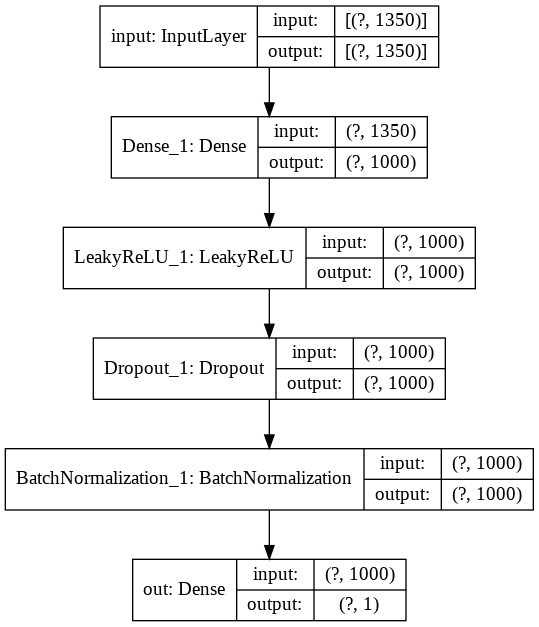

In [ ]:
keras.utils.plot_model(model.predictor,expand_nested=True,show_shapes=True)


In [ ]:
model.predictor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1350)]            0         
_________________________________________________________________
Dense_1 (Dense)              (None, 1000)              1351000   
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 1000)              0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
BatchNormalization_1 (BatchN (None, 1000)              4000      
_________________________________________________________________
out (Dense)                  (None, 1)                 1001      
Total params: 1,356,001
Trainable params: 1,354,001
Non-trainable params: 2,000
_______________________________________________

# Генетика

In [ ]:
! pip install git+https://github.com/prog815/abscur
from abscur.optim import ListGenetic

  Cloning https://github.com/prog815/abscur to /tmp/pip-req-build-kupe0sxq
  Running command git clone -q https://github.com/prog815/abscur /tmp/pip-req-build-kupe0sxq
  Created wheel for abscur: filename=abscur-0.1.27-cp36-none-any.whl size=10205 sha256=58a150bafb1d3d4955d0b0b360e618eee5a1129aca62bb39318e21a99d075027
  Stored in directory: /tmp/pip-ephem-wheel-cache-4q04jdcx/wheels/57/99/b6/8f8d84361b37a8789f91280c8e92720b9101beffb944cd32ab
Successfully built abscur


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def getQualityMethod(size1,size2,dropoutRate,kernelReg,learning_rate):
    X_learn, y_learn, X_estimate, y_estimate = db.getRandValid()
    
    model = SimpleModel(inputs=X_estimate.shape[1],
                        sizes=(size1,size2),
                        dropoutRate=dropoutRate,
                        kernelReg=kernelReg,
                        learning_rate=learning_rate)
    model.fit(X_learn,y_learn > 0)
    return model.evaluate(X_estimate, y_estimate>0)[1]


modelGA = ListGenetic(size1=np.arange(3,500),
                      size2=np.arange(3,500),
                      dropoutRate=np.arange(0.1,0.9,0.01),
                      kernelReg=np.arange(0.001,0.999,0.0001),
                      learning_rate=np.arange(0.001,0.999,0.0001),
                      quality_method=getQualityMethod)

modelGA.fit(30)


1 {'quality': 0.6000000238418579, 'size1': 358, 'size2': 301, 'dropoutRate': 0.13, 'kernelReg': 0.8449000000000004, 'learning_rate': 0.7459000000000003}
2 {'quality': 0.20000000298023224, 'size1': 358, 'size2': 222, 'dropoutRate': 0.15999999999999998, 'kernelReg': 0.9772000000000004, 'learning_rate': 0.09550000000000004}
3 {'quality': 0.4000000059604645, 'size1': 58, 'size2': 124, 'dropoutRate': 0.6199999999999998, 'kernelReg': 0.1980000000000001, 'learning_rate': 0.028800000000000013}
4 {'quality': 1.0, 'size1': 182, 'size2': 307, 'dropoutRate': 0.6699999999999997, 'kernelReg': 0.9719000000000004, 'learning_rate': 0.2291000000000001}
5 {'quality': 0.20000000298023224, 'size1': 65, 'size2': 131, 'dropoutRate': 0.13999999999999999, 'kernelReg': 0.19280000000000008, 'learning_rate': 0.05120000000000002}
6 {'quality': 0.6000000238418579, 'size1': 93, 'size2': 458, 'dropoutRate': 0.5399999999999998, 'kernelReg': 0.7530000000000003, 'learning_rate': 0.37160000000000015}
7 {'quality': 0.4000

In [ ]:
modelGA.fit(1000)


2339 {'quality': 0.6000000238418579, 'size1': 182, 'size2': 81, 'dropoutRate': 0.5799999999999997, 'kernelReg': 0.9552000000000004, 'learning_rate': 0.062200000000000026}
2340 {'quality': 0.20000000298023224, 'size1': 176, 'size2': 369, 'dropoutRate': 0.5799999999999997, 'kernelReg': 0.9532000000000004, 'learning_rate': 0.06680000000000003}
2341 {'quality': 0.4000000059604645, 'size1': 182, 'size2': 331, 'dropoutRate': 0.5199999999999998, 'kernelReg': 0.9844000000000005, 'learning_rate': 0.015700000000000006}
2342 {'quality': 0.4000000059604645, 'size1': 184, 'size2': 334, 'dropoutRate': 0.5099999999999998, 'kernelReg': 0.9668000000000004, 'learning_rate': 0.0020000000000000005}
2343 {'quality': 0.4000000059604645, 'size1': 172, 'size2': 342, 'dropoutRate': 0.4999999999999998, 'kernelReg': 0.9534000000000005, 'learning_rate': 0.05790000000000003}
2344 {'quality': 0.20000000298023224, 'size1': 171, 'size2': 338, 'dropoutRate': 0.4999999999999998, 'kernelReg': 0.9696000000000005, 'learni

KeyboardInterrupt: ignored

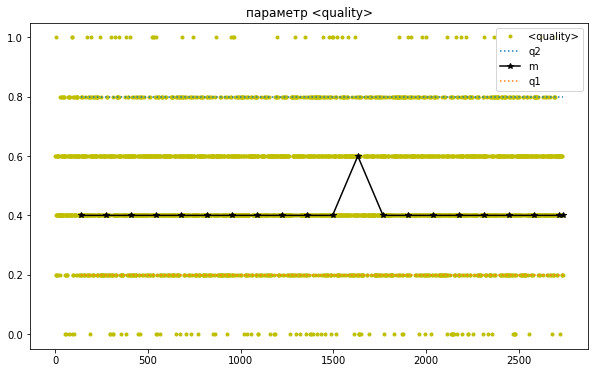

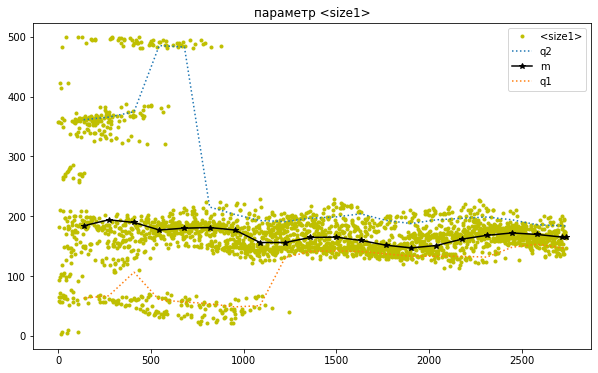

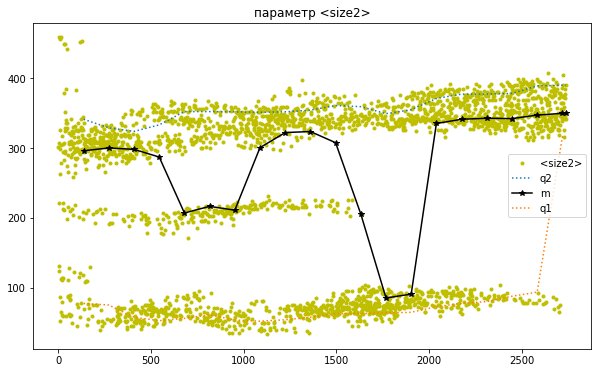

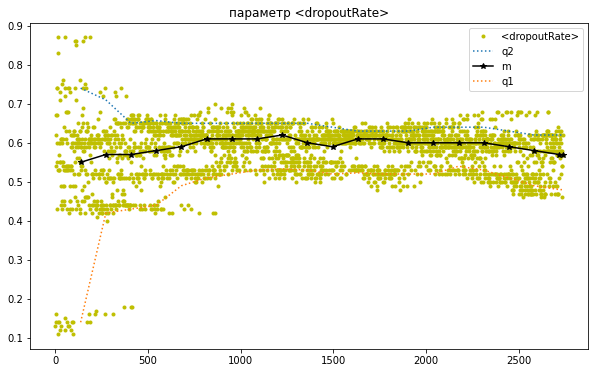

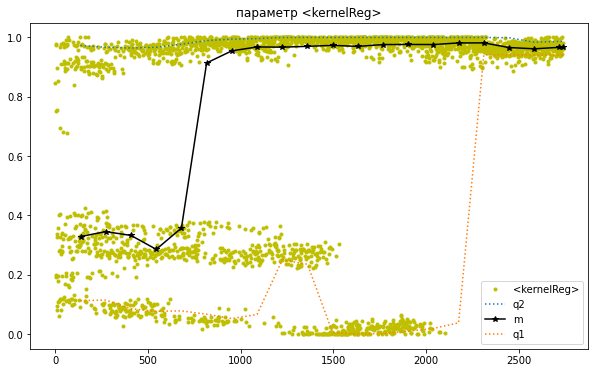

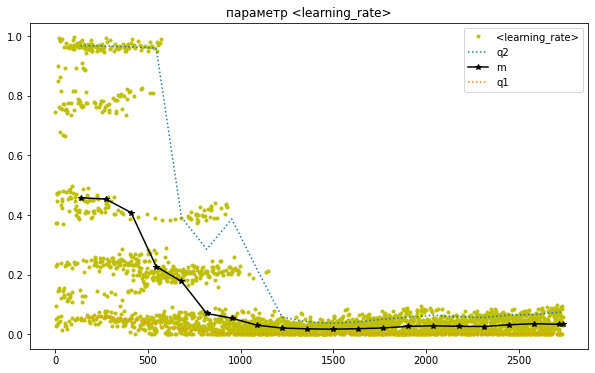

In [ ]:
modelGA.plot_hist_new(('quality','size1','size2','dropoutRate','kernelReg','learning_rate'))